In [237]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import ast
import sklearn

df = pd.read_csv("../2_clean_data/final_combine_data.csv")

In [238]:
#Columns with lists are represented as strings, so this is converting them into list/np.array types

for index, row in df.iterrows():
    df.iloc[index]['salaries'] = ast.literal_eval(df.iloc[index]['salaries'])
    df.iloc[index]['semester'] = ast.literal_eval(df.iloc[index]['semester'])
    df.iloc[index]['years_taught'] = ast.literal_eval(df.iloc[index]['years_taught'])
    df.iloc[index]['course'] = ast.literal_eval(df.iloc[index]['course'])
    df.iloc[index]['average_rating'] = np.fromstring(df.iloc[index]['average_rating'].strip("[]"), sep=',')
    df.iloc[index]['num_reviews'] = np.fromstring(df.iloc[index]['num_reviews'].strip("[]"), sep=',')
    df.iloc[index]['average_gpa'] = np.fromstring(df.iloc[index]['average_gpa'].strip("[]"), sep=',')
    df.iloc[index]['num_students'] = ast.literal_eval(df.iloc[index]['num_students'])
    


#json.loads(df.iloc[0]['salaries'])[0]

In [239]:
import re
df = df.drop([1615, 1616])
# Getting the minimum year
df['min_year'] = df['years_taught'].apply(lambda x: min([sem for sem in x]))
# Getting lifespan of professor from first year taught to current semester that is being taught
df['year'] = df['semester'].apply(lambda x: min([sem.split(" ")[1] for sem in x]))
df['min_year'] = df[['min_year', 'year']].min(axis=1)
df = df.drop(['year'], axis=1)
df = df.explode(['course', 'semester', 'average_rating', 'num_reviews', 'average_gpa', 'num_students'])
df['curr_year'] = df['semester'].apply(lambda x: int(x.split(" ")[1]))
df['lifetime'] = df['curr_year'] - df['min_year']
df.loc[df['lifetime'] < 0, 'lifetime'] = np.nan


/var/folders/rz/_3n38h1s6gq_8gmr401zq62r0000gn/T/ipykernel_14250/3508245765.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['min_year'] = df[['min_year', 'year']].min(axis=1)


In [240]:
df

,name,course,semester,average_rating,num_reviews,average_gpa,num_students,years_taught,salaries,departments,real_name(s),_merge,min_year,curr_year,lifetime
0,A SHARMA,ASTR300,fall 2019,1.0,1.0,NaN,0,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,2013,2019,6
0,A SHARMA,ASTR300,spring 2019,1.5,2.0,2.85,57,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,2013,2019,6
0,A SHARMA,ASTR300,fall 2020,2.0,1.0,NaN,0,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,2013,2020,7
0,A SHARMA,ASTR300,winter 2021,3.0,1.0,NaN,0,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,2013,2021,8
0,A SHARMA,ASTR300,fall 2016,NaN,NaN,2.92,51,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,2013,2016,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437,TIM KIEMEL,KNES497,spring 2018,NaN,NaN,3.71,20,"[2015, 2016, 2017, 2018, 2019, 2020, 2021, 202...","[35621.46, 35621.46, 35621.46, 35621.46, 72667...","['SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL...","Kiemel, Tim",both,2013,2018,5
2437,TIM KIEMEL,KNES689D,spring 2013,NaN,NaN,4.0,7,"[2015, 2016, 2017, 2018, 2019, 2020, 2021, 202...","[35621.46, 35621.46, 35621.46, 35621.46, 72667...","['SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL...","Kiemel, Tim",both,2013,2013,0
2437,TIM KIEMEL,KNES689D,spring 2017,NaN,NaN,4.0,9,"[2015, 2016, 2017, 2018, 2019, 2020, 2021, 202...","[35621.46, 35621.46, 35621.46, 35621.46, 72667...","['SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL...","Kiemel, Tim",both,2013,2017,4
2437,TIM KIEMEL,KNES689M,spring 2015,NaN,NaN,4.0,5,"[2015, 2016, 2017, 2018, 2019, 2020, 2021, 202...","[35621.46, 35621.46, 35621.46, 35621.46, 72667...","['SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL...","Kiemel, Tim",both,2013,2015,2


In [99]:
for index, row in df.iterrows():
    # if len(row['course']) * 6 != len(row['course']) + len(row['semester']) + len(row['average_rating']) + len(row['num_reviews']) + len(row['average_gpa']) + len(row['num_students']):
    #     print('in here')
    
    # for x in zip(row['course'], row['semester'], row['average_rating'], row['num_reviews'], row['average_gpa'], row['num_students']):
    #     print(list(x))
    # print('done')
    
    if len(row['salaries']) * 3 == len(row['years_taught']) + len(row['salaries']) + len(row['departments']):
        print('in here')
        


In [100]:
#Create column storing combined course data and salary data

#order for combined_course_info is [course, semester, average_rating, num_reviews, average_gpa,
# num_students]]

df['combined_salary_info'] = np.empty((len(df), 0)).tolist()

for index, row in df.iterrows():
#     for i in range(len(row['course'])):
#         df.iloc[index]['combined_course_info'].extend([list(x) for x in zip(row['course'], row['semester'], row['average_rating'], row['num_reviews'], row['average_gpa'], row['num_students'])])
    
    for i in range(len(row['salaries'])):
        df.iloc[index]['combined_salary_info'].extend([list(x) for x in zip(row['salaries'], row['years_taught'])])

In [101]:
df[['sem', 'year']] = df['semester'].str.split(' ', 1, expand=True)

/var/folders/rz/_3n38h1s6gq_8gmr401zq62r0000gn/T/ipykernel_14250/2949145723.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['sem', 'year']] = df['semester'].str.split(' ', 1, expand=True)


In [102]:
df['sem']

0         fall
0       spring
0         fall
0       winter
0         fall
         ...  
2437    spring
2437    spring
2437    spring
2437    spring
2437    spring
Name: sem, Length: 52082, dtype: object

In [103]:
df = df[["name", "course", "sem", "year", "average_rating", "num_reviews", "average_gpa", "num_students", "Employee", "years_taught", "salaries", "departments", "_merge", "semester"]]


KeyError: "['Employee'] not in index"

In [ ]:
df.head()

,name,course,semester,average_rating,num_reviews,average_gpa,num_students,Employee,years_taught,salaries,departments,_merge,sem,year
0,A KRUGLANSKI,PSYC489H,fall 2015,2.0,1.0,NaN,0,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,fall,2015
0,A KRUGLANSKI,PSYC489H,spring 2014,NaN,NaN,3.51,16,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2014
0,A KRUGLANSKI,PSYC489H,spring 2015,NaN,NaN,3.55,8,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2015
0,A KRUGLANSKI,PSYC489T,spring 2017,NaN,NaN,3.89,17,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2017
0,A KRUGLANSKI,PSYC489T,spring 2019,NaN,NaN,3.46,20,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2019


In [ ]:
df

0         fall
0       spring
0       spring
0       spring
0       spring
         ...  
2696    spring
2696      fall
2696      fall
2696      fall
2696    spring
Name: _merge, Length: 58301, dtype: object

In [ ]:
df.head()

,name,course,sem,year,average_rating,num_reviews,average_gpa,num_students,Employee,years_taught,salaries,departments,_merge,semester
0,A KRUGLANSKI,PSYC489H,fall 2015,2.0,1.0,NaN,0,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,fall,2015
0,A KRUGLANSKI,PSYC489H,spring 2014,NaN,NaN,3.51,16,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2014
0,A KRUGLANSKI,PSYC489H,spring 2015,NaN,NaN,3.55,8,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2015
0,A KRUGLANSKI,PSYC489T,spring 2017,NaN,NaN,3.89,17,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2017
0,A KRUGLANSKI,PSYC489T,spring 2019,NaN,NaN,3.46,20,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2019


In [ ]:
df[df['name'] == 'AHMAD KARIMI-HAKKAK'].sort_values(by='semester')

,name,course,semester,average_rating,num_reviews,average_gpa,num_students,Employee,years_taught,salaries,departments,_merge,combined_salary_info
32,AHMAD KARIMI-HAKKAK,PERS283,fall 2013,NaN,NaN,3.54,17,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[8949.58, 2015], [29107.38, 2016], [8949.58, ..."
32,AHMAD KARIMI-HAKKAK,PERS452,fall 2013,NaN,NaN,3.58,4,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[210000.0, 2013], [221707.5, 2014], [231361.6..."
32,AHMAD KARIMI-HAKKAK,PERS283,fall 2015,NaN,NaN,3.12,24,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[30000.0, 2017], [33000.0, 2018], [33660.0, 2..."
32,AHMAD KARIMI-HAKKAK,PERS371,fall 2015,NaN,NaN,3.11,10,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[85000.0, 2018], [86700.0, 2019], [111100.0, ..."
32,AHMAD KARIMI-HAKKAK,PERS283,fall 2016,NaN,NaN,3.56,14,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[39981.96, 2021], [41391.32, 2022], [39981.96..."
32,AHMAD KARIMI-HAKKAK,PERS371,fall 2016,NaN,NaN,3.63,7,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[95512.4, 2013], [100663.24, 2014], [105087.5..."
32,AHMAD KARIMI-HAKKAK,PERS371,spring 2011,5.0,1.0,NaN,0,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[95884.44, 2013], [95395.97, 2014], [99486.71..."
32,AHMAD KARIMI-HAKKAK,PERS302,spring 2012,NaN,NaN,3.63,19,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[27474.72, 2013], [82400.0, 2014], [85939.08,..."
32,AHMAD KARIMI-HAKKAK,PERS353,spring 2012,NaN,NaN,3.43,36,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[138020.0, 2014], [143244.07, 2015], [143244...."
32,AHMAD KARIMI-HAKKAK,PERS402,spring 2013,NaN,NaN,3.7,15,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[91181.59, 2013], [100293.98, 2014], [104195...."


In [ ]:
#Professors that have taught in 2015

taught_in_2015 = df[df['semester'].apply(lambda x: '2015' in x)]
salaries = []

count = 0
for index, row in taught_in_2015.iterrows():
    if 2015 not in row['years_taught']:
        count +=1
        print(row)
        
#print(count)
    #salaries.append(row['salaries'][row['years_taught'].index(2015)])



name                                                          ABRAM KAGAN
course                                                            STAT410
semester                                                      spring 2015
average_rating                                                        NaN
num_reviews                                                           NaN
average_gpa                                                          3.07
num_students                                                           18
Employee                                                  Kagan, Abram M.
years_taught                                                 [2018, 2019]
salaries                                            [127678.72, 136309.8]
departments                                              ['CMNS', 'CMNS']
_merge                                                               both
combined_salary_info    [[98000.0, 2018], [99960.0, 2019], [104508.33,...
Name: 13, dtype: object
name          

In [ ]:
print(len(taught_in_2015))

NameError: name 'taught_in_2015' is not defined

In [ ]:
taught_in_2015

,name,course,semester,average_rating,num_reviews,average_gpa,num_students,Employee,years_taught,salaries,departments,_merge,combined_salary_info
0,A KRUGLANSKI,PSYC489H,fall 2015,2.0,1.0,NaN,0,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,"[[289244.91, 2015], [289244.91, 2016], [296487..."
0,A KRUGLANSKI,PSYC489H,spring 2015,NaN,NaN,3.55,8,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,"[[118132.88, 2013], [122857.87, 2014], [126568..."
2,A.U. SHANKAR,CMSC412,spring 2015,NaN,NaN,2.99,40,"Shankar, A.U.","[2013, 2014, 2015, 2016, 2017, 2018, 2019]","[118132.88, 122857.87, 126568.18, 63284.09, 12...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,"[[109422.16, 2013], [115508.16, 2014], [136609..."
8,ABHIJIT DASGUPTA,ENME470,fall 2015,NaN,NaN,3.43,41,"Dasgupta, Abhijit","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[167138.22, 183580.92, 190895.4, 190895.4, 198...","['ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR...",both,"[[89760.0, 2021], [92924.04, 2022], [89760.0, ..."
8,ABHIJIT DASGUPTA,ENME684,spring 2015,NaN,NaN,3.76,9,"Dasgupta, Abhijit","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[167138.22, 183580.92, 190895.4, 190895.4, 198...","['ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR...",both,"[[90780.0, 2019], [94910.63, 2020], [96808.84,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2689,ZHANQING LI,AOSC401,spring 2015,NaN,NaN,3.39,22,"Li, Zhanqing","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[144851.72, 150397.28, 174363.52000000002, 174...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,[]
2692,ZHONGCHI LIU,BSCI378H,spring 2015,NaN,NaN,3.95,19,"Liu, Zhongchi","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[102000.22, 106475.0, 111318.72, 111318.72, 11...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,[]
2693,ZITA NUNES,ENGL301,fall 2015,NaN,NaN,2.91,20,"Nunes, Zita Cristina","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[95042.18, 99216.19, 102806.89, 102806.89, 125...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU...",both,[]
2693,ZITA NUNES,ENGL748J,fall 2015,NaN,NaN,3.51,10,"Nunes, Zita Cristina","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[95042.18, 99216.19, 102806.89, 102806.89, 125...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU...",both,[]


In [ ]:
# for index, row in df.iterrows():
#     if df.iloc[index]['years_taught'].contains(2015):
        

['spring 2009',
 'summer 2008',
 'fall 2009',
 'spring 2009',
 'fall 2014',
 'fall 2015',
 'fall 2016',
 'fall 2017',
 'fall 2018',
 'fall 2012']

array([ 4.,  5.,  5.,  3., nan, nan, nan, nan, nan, nan])

In [ ]:
#sns.scatterplot(x=df.iloc[120]['years_taught'], y=df.iloc[120]['salaries'])
print(df.iloc[150])
# sns.scatterplot(x=df.iloc[150]['semester'], y=df.iloc[150]['average_rating'])

name                                                       ABIGAIL MCEWEN
course                                                            ARTH260
semester                                                        fall 2019
average_rating                                                        NaN
num_reviews                                                           NaN
average_gpa                                                          3.56
num_students                                                           96
years_taught            [2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...
salaries                [64260.0, 70608.2, 73910.42, 73910.42, 82910.4...
departments             ['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU...
real_name(s)                                              McEwen, Abigail
_merge                                                               both
combined_salary_info    [[137258.0, 2013], [148091.82, 2014], [178753....
sem                                   

ValueError: Could not interpret value `fall 2019` for parameter `x`

In [241]:
# Getting current salary
# get the current year, get the index in years taught, get the value of salaries at that index
def getIndex(year, array):
    differenceArray = np.absolute(np.array(array)-year)
    return differenceArray.argmin()
def getSalary(index, salary):
    return salary[index]
df['index'] = df.apply(lambda x: getIndex(x['curr_year'], x['years_taught']), axis=1)
df['current_salary'] = df.apply(lambda x: getSalary(x['index'], x['salaries']), axis=1)
df = df.drop('index', axis=1)

In [242]:
df

,name,course,semester,average_rating,num_reviews,average_gpa,num_students,years_taught,salaries,departments,real_name(s),_merge,min_year,curr_year,lifetime,current_salary
0,A SHARMA,ASTR300,fall 2019,1.0,1.0,NaN,0,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,2013,2019,6,86528.86
0,A SHARMA,ASTR300,spring 2019,1.5,2.0,2.85,57,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,2013,2019,6,86528.86
0,A SHARMA,ASTR300,fall 2020,2.0,1.0,NaN,0,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,2013,2020,7,82844.37
0,A SHARMA,ASTR300,winter 2021,3.0,1.0,NaN,0,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,2013,2021,8,82844.37
0,A SHARMA,ASTR300,fall 2016,NaN,NaN,2.92,51,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,2013,2016,3,76537.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437,TIM KIEMEL,KNES497,spring 2018,NaN,NaN,3.71,20,"[2015, 2016, 2017, 2018, 2019, 2020, 2021, 202...","[35621.46, 35621.46, 35621.46, 35621.46, 72667...","['SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL...","Kiemel, Tim",both,2013,2018,5,35621.46
2437,TIM KIEMEL,KNES689D,spring 2013,NaN,NaN,4.0,7,"[2015, 2016, 2017, 2018, 2019, 2020, 2021, 202...","[35621.46, 35621.46, 35621.46, 35621.46, 72667...","['SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL...","Kiemel, Tim",both,2013,2013,0,34922.99
2437,TIM KIEMEL,KNES689D,spring 2017,NaN,NaN,4.0,9,"[2015, 2016, 2017, 2018, 2019, 2020, 2021, 202...","[35621.46, 35621.46, 35621.46, 35621.46, 72667...","['SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL...","Kiemel, Tim",both,2013,2017,4,35621.46
2437,TIM KIEMEL,KNES689M,spring 2015,NaN,NaN,4.0,5,"[2015, 2016, 2017, 2018, 2019, 2020, 2021, 202...","[35621.46, 35621.46, 35621.46, 35621.46, 72667...","['SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL...","Kiemel, Tim",both,2013,2015,2,35621.46


In [273]:
# Getting and splitting dataset into training and testing data

lifeTimeGrades = df[['lifetime', 'average_gpa']]
lifeTimeGrades.dropna(inplace=True)
lifeTimeRating = df[['lifetime', 'average_rating']]
lifeTimeRating.dropna(inplace=True)
salaryGrades = df[['current_salary', 'average_gpa']]
salaryGrades.dropna(inplace=True)
salaryRating = df[['current_salary', 'average_rating']]
salaryRating.dropna(inplace=True)
lsGrades = df[['lifetime', 'current_salary', 'average_gpa']]
lsGrades.dropna(inplace=True)
lsRating = df[['lifetime', 'current_salary', 'average_rating']]
lsRating.dropna(inplace=True)


/var/folders/rz/_3n38h1s6gq_8gmr401zq62r0000gn/T/ipykernel_14250/2850740419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lifeTimeGrades.dropna(inplace=True)
/var/folders/rz/_3n38h1s6gq_8gmr401zq62r0000gn/T/ipykernel_14250/2850740419.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lifeTimeRating.dropna(inplace=True)
/var/folders/rz/_3n38h1s6gq_8gmr401zq62r0000gn/T/ipykernel_14250/2850740419.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

0.00951147070682945


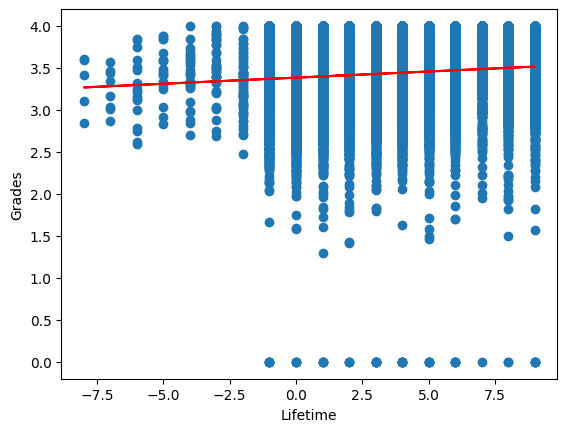

-0.0014370002224635137


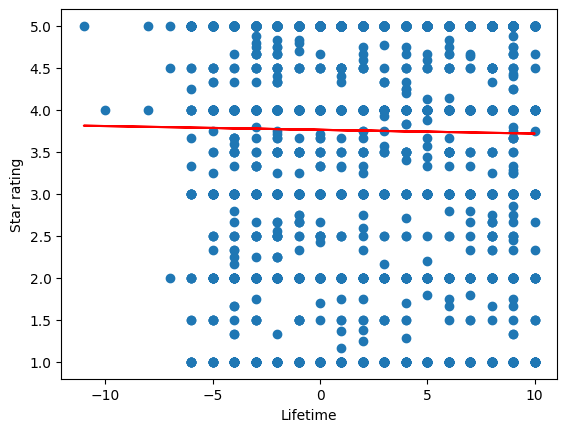

0.0005703184833627528


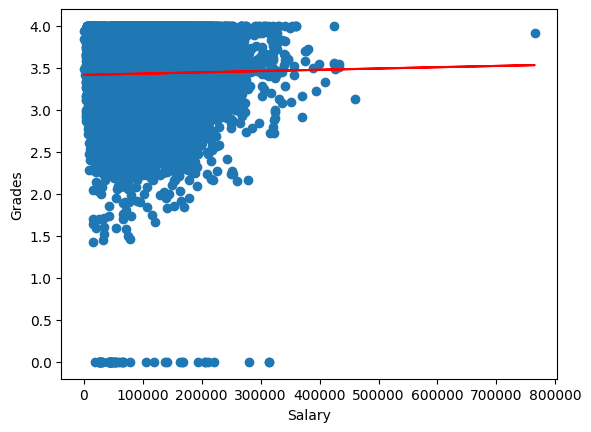

0.0011975547069077441


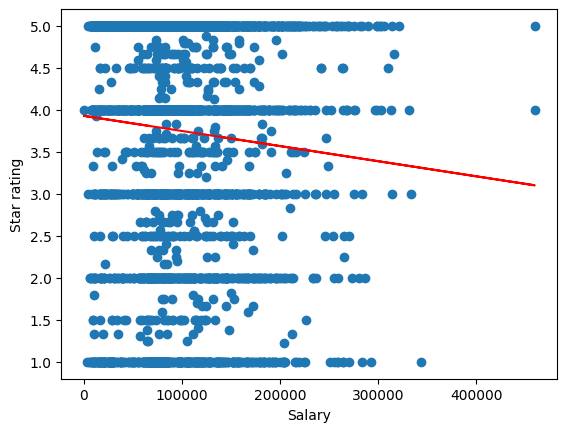

0.009205453658788443
0.0023668733136528175


/Users/aaronlin/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/aaronlin/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/aaronlin/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/aaronlin/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [274]:
import sklearn.model_selection
import sklearn.linear_model
# Linear Regression Analysis

# Regression of lifetime vs grades
lifetime_train, lifetime_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lifeTimeGrades['lifetime'], lifeTimeGrades['average_gpa'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(lifetime_train).reshape(-1,1), grade_train)
print(linear.score(np.array(lifetime_test).reshape(-1,1), grade_test))
gradePredict = linear.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), grade_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), gradePredict, color='red')
plt.xlabel('Lifetime')
plt.ylabel('Grades')
plt.show()

# Regression of lifetime vs starRating
lifetime_train, lifetime_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lifeTimeRating['lifetime'], lifeTimeRating['average_rating'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(lifetime_train).reshape(-1,1), rating_train)
print(linear.score(np.array(lifetime_test).reshape(-1,1), rating_test))
ratingPredict = linear.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), rating_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), ratingPredict, color='red')
plt.xlabel('Lifetime')
plt.ylabel('Star rating')
plt.show()

# Regression of salary vs grades
salary_train, salary_test, grade_train, grade_test = sklearn.model_selection.train_test_split(salaryGrades['current_salary'], salaryGrades['average_gpa'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(salary_train).reshape(-1,1), grade_train)
print(linear.score(np.array(salary_test).reshape(-1,1), grade_test))
gradePredict = linear.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), grade_test)
plt.plot(np.array(salary_test).reshape(-1,1), gradePredict, color='red')
plt.xlabel('Salary')
plt.ylabel('Grades')
plt.show()
# Regression of salary vs starRating
salary_train, salary_test, rating_train, rating_test = sklearn.model_selection.train_test_split(salaryRating['current_salary'], salaryRating['average_rating'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(salary_train).reshape(-1,1), rating_train)
print(linear.score(np.array(salary_test).reshape(-1,1), rating_test))
ratingPredict = linear.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), rating_test)
plt.plot(np.array(salary_test).reshape(-1,1), ratingPredict, color='red')
plt.xlabel('Salary')
plt.ylabel('Star rating')
plt.show()

# 3d Regression of salary and lifetime as x variables and grades as y variable
X = lsGrades.drop('average_gpa', axis=1)
y = lsGrades['average_gpa']
ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(ls_train), grade_train)
print(linear.score(ls_test, grade_test))
gradePredict = linear.predict(ls_test)

# 3d Regression of salary and lifetime as x variables and star rating as y variable
X = lsRating.drop('average_rating', axis=1)
y = lsRating['average_rating']
ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(ls_train), rating_train)
print(linear.score(ls_test, rating_test))
ratingPredict = linear.predict(ls_test)

0.7519232178181552


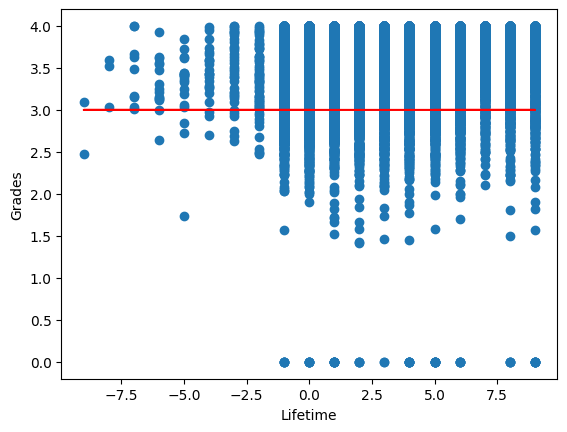

0.43032202906811057


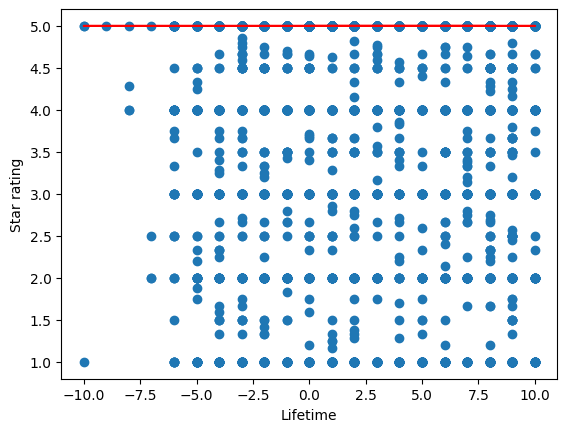

0.7644516081764232


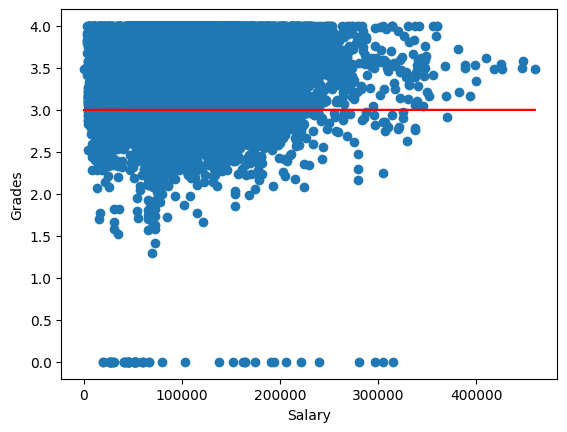

0.43003704759190653


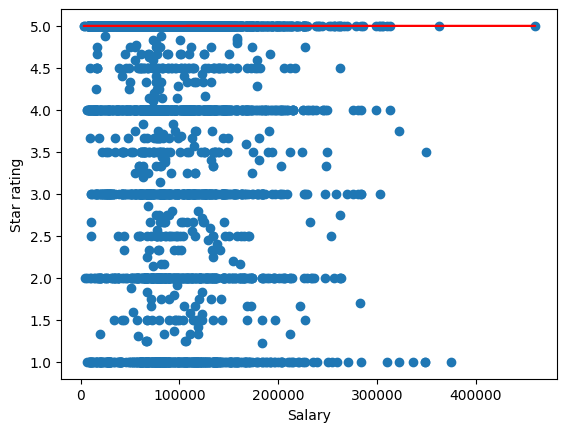

0.7579309839548685
0.4160729552579082


/Users/aaronlin/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/aaronlin/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/aaronlin/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/aaronlin/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [275]:
# The reason it shows up as a straight line is because it is the beginning / the end of the log function so it is only showing the straight line portion of the graph

#Regression of liftime vs grades
lifetime_train, lifetime_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lifeTimeGrades['lifetime'], lifeTimeGrades['average_gpa'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(lifetime_train).reshape(-1,1), grade_train.astype('int'))
print(logistic.score(np.array(lifetime_test).reshape(-1,1), grade_test.astype('int')))
gradePredict = logistic.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), grade_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), gradePredict, color='red')
plt.xlabel('Lifetime')
plt.ylabel('Grades')
plt.show()

# Regression of lifetime vs starRating
lifetime_train, lifetime_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lifeTimeRating['lifetime'], lifeTimeRating['average_rating'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(lifetime_train).reshape(-1,1), rating_train.astype('int'))
print(logistic.score(np.array(lifetime_test).reshape(-1,1), rating_test.astype('int')))
ratingPredict = logistic.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), rating_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), ratingPredict, color='red')
plt.xlabel('Lifetime')
plt.ylabel('Star rating')
plt.show()

# Regression of salary vs grades
salary_train, salary_test, grade_train, grade_test = sklearn.model_selection.train_test_split(salaryGrades['current_salary'], salaryGrades['average_gpa'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(salary_train).reshape(-1,1), grade_train.astype('int'))
print(logistic.score(np.array(salary_test).reshape(-1,1), grade_test.astype('int')))
gradePredict = logistic.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), grade_test)
plt.plot(np.array(salary_test).reshape(-1,1), gradePredict, color='red')
plt.xlabel('Salary')
plt.ylabel('Grades')
plt.show()

# Regression of salary vs starRating
salary_train, salary_test, rating_train, rating_test = sklearn.model_selection.train_test_split(salaryRating['current_salary'], salaryRating['average_rating'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(salary_train).reshape(-1,1), rating_train.astype('int'))
print(logistic.score(np.array(salary_test).reshape(-1,1), rating_test.astype('int')))
ratingPredict = logistic.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), rating_test)
plt.plot(np.array(salary_test).reshape(-1,1), ratingPredict, color='red')
plt.xlabel('Salary')
plt.ylabel('Star rating')
plt.show()

# 3d Regression of salary and lifetime as x variables and grades as y variable
X = lsGrades.drop('average_gpa', axis=1)
y = lsGrades['average_gpa']
ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(ls_train), grade_train.astype('int'))
print(logistic.score(ls_test, grade_test.astype('int')))
gradePredict = logistic.predict(ls_test)

# 3d Regression of salary and lifetime as x variables and star rating as y variable
X = lsRating.drop('average_rating', axis=1)
y = lsRating['average_rating']
ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(ls_train), rating_train.astype('int'))
print(logistic.score(ls_test, rating_test.astype('int')))
ratingPredict = logistic.predict(ls_test)

In [271]:
# Creating categorized values for SVM
# teacherLifetime = df['lifetime']
# teacherSalaries = df['current_salary']
# grades = df['average_gpa']
# starRating = df['average_rating']
# nlpRating = []
# df['lifetimeSalary'] = [list(elt) for elt in zip(teacherLifetime, teacherSalaries)]
categorizedGrade = []
grades.dropna(inplace=True)
for grade in grades:
    if grade > 3.7:
        categorizedGrade.append("A")
    elif grade > 3.3:
        categorizedGrade.append("A-")
    elif grade > 3.0:
        categorizedGrade.append("B+")
    elif grade > 2.7:
        categorizedGrade.append("B")
    elif grade > 2.3:
        categorizedGrade.append("B-")
    elif grade > 2.0:
        categorizedGrade.append("C+")
    elif grade > 1.7:
        categorizedGrade.append("C")
    elif grade > 1.3:
        categorizedGrade.append("C-")
    elif grade > 1.0:
        categorizedGrade.append("D+")
    elif grade > 0.7:
        categorizedGrade.append("D")
    else:
        categorizedGrade.append("F")

lifeTimeGrades = df[['lifetime', 'average_gpa']]
lifeTimeGrades.dropna(inplace=True)
lifeTimeRating = df[['lifetime', 'average_rating']]
lifeTimeRating.dropna(inplace=True)
salaryGrades = df[['current_salary', 'average_gpa']]
salaryGrades.dropna(inplace=True)
salaryRating = df[['current_salary', 'average_rating']]
salaryRating.dropna(inplace=True)
lsGrades = df[['lifetime', 'current_salary', 'average_gpa']]
lsGrades.dropna(inplace=True)
lsRating = df[['lifetime', 'current_salary', 'average_rating']]
lsRating.dropna(inplace=True)

starRating.dropna(inplace=True)
categorizedRating = [int(rating) for rating in starRating]


In [272]:
# SVM Analysis

# SVM of lifetime and grades
lifetime_train, lifetime_test, grade_train, grade_test = sklearn.model_selection.train_test_split(teacherLifetime, categorizedGrade, test_size=0.3)
svm = sklearn.svm.SVC().fit(teacherLifetime, categorizedGrade)
svm.score(lifetime_test, grade_test)
gradePredict = svm.predict(lifetime_test)

# SVM of lifetime and ratings
lifetime_train, lifetime_test, rating_train, rating_test = sklearn.model_selection.train_test_split(teacherLifetime, categorizedRating, test_size=0.3)
svm = sklearn.svm.SVC().fit(teacherLifetime, categorizedRating)
svm.score(lifetime_test, rating_test)
ratingPredict = svm.predict(lifetime_test)

# SVM of salary and grades
salary_train, salary_test, grade_train, grade_test = sklearn.model_selection.train_test_split(teacherSalaries, categorizedGrade, test_size=0.3)
svm = sklearn.svm.SVC().fit(teacherSalaries, categorizedGrade)
svm.score(salary_test, grade_test)
gradePredict = svm.predict(salary_test)

# SVM of salary and ratings
salary_train, salary_test, rating_train, rating_test = sklearn.model_selection.train_test_split(teacherSalaries, categorizedRating, test_size=0.3)
svm = sklearn.svm.SVC().fit(teacherSalaries, categorizedRating)
svm.score(salary_test, rating_test)
ratingPredict = svm.predict(salary_test)

# SVM of lifetime and salary vs grades
ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lifetimeSalary, categorizedGrade, test_size=0.3)
svm = sklearn.svm.SVC().fit(lifetimeSalary, categorizedGrade)
svm.score(ls_test, grade_test)
gradePredict = svm.predict(ls_test)

# SVM of lifetime and salary vs rating
ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lifetimeSalary, categorizedRating, test_size=0.3)
svm = sklearn.svm.SVC().fit(lifetimeSalary, categorizedRating)
svm.score(ls_test, rating_test)
ratingPredict = svm.predict(ls_test)

ValueError: Found input variables with inconsistent numbers of samples: [52082, 45496]

In [ ]:
# KNN Analysis

# KNN of lfetime and grade
lifetime_train, lifetime_test, grade_train, grade_test = sklearn.model_selection.train_test_split(teacherLifetime, categorizedGrade, test_size=0.3)
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5).fit(teacherLifetime, categorizedGrade)
knn.score(lifetime_test, grade_test)
gradePredict = knn.predict(lifetime_test)

# KNN of lifetime and rating
lifetime_train, lifetime_test, rating_train, rating_test = sklearn.model_selection.train_test_split(teacherLifetime, categorizedRating, test_size=0.3)
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5).fit(teacherLifetime, categorizedRating)
knn.score(lifetime_test, rating_test)
ratingPredict = knn.predict(lifetime_test)

# KNN of salary and grade
salary_train, salary_test, grade_train, grade_test = sklearn.model_selection.train_test_split(teacherSalaries, categorizedGrade, test_size=0.3)
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5).fit(teacherSalaries, categorizedGrade)
knn.score(salary_test, grade_test)
gradePredict = knn.predict(salary_test)

# KNN of salary and rating
salary_train, salary_test, rating_train, rating_test = sklearn.model_selection.train_test_split(teacherSalaries, categorizedRating, test_size=0.3)
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5).fit(teacherSalaries, categorizedRating)
knn.score(salary_test, rating_test)
ratingPredict = knn.predict(salary_test)

# KNN of lifetime and salary vs grade
ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lifetimeSalary, categorizedGrade, test_size=0.3)
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5).fit(lifetimeSalary, categorizedGrade)
knn.score(ls_test, grade_test)
gradePredict = knn.predict(ls_test)

# KNN of lifetime and salary vs rating
ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lifetimeSalary, categorizedRating, test_size=0.3)
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5).fit(lifetimeSalary, categorizedRating)
knn.score(ls_test, rating_test)
ratingPredict = knn.predict(ls_test)